
#### Environment setup



In [1]:
begin
	# Activate project environment
	import Pkg
	Pkg.activate(".")
	
	# SciML Tools
	import OrdinaryDiffEq, ModelingToolkit, SciMLSensitivity, Optimization, OptimizationOptimisers, OptimizationOptimJL, LineSearches, Symbolics
	
	# Standard Libraries
	using StatsBase, ComponentArrays, JLD2
	
    # Module for custom RBF activation function
	include("RBF.jl")
	using .RBF
	
	# External Libraries
	using Lux, Zygote, Plots, StableRNGs, DataFrames, CSV, SmoothingSplines, ColorSchemes
	
    # Explicitly call the default backend for Plots
	gr()
	
	# Set a random seed for reproducible behaviour
	rng = StableRNG(1111)
end

  Activating project at `~/Documents/Master/MasterThesis/UDE/DataDrivenEquationDiscovery`
Precompiling LuxZygoteExt
        Info Given LuxZygoteExt was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? Lux → LuxZygoteExt
[ Info: Precompiling LuxZygoteExt [df13723f-0f22-5fb0-8a8f-885eac2ce1ee]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing LuxZygoteExt [df13723f-0f22-5fb0-8a8f-885eac2ce1ee].


StableRNGs.LehmerRNG(state=0x000000000000000000000000000008af)


# UDE approximation
This notebook contains the code to define and solve a Universal Differential Equation (UDE) system, taking inspiration from the SciML tutorial ["Automatically Discover Missing Physics by Embedding Machine Learning into Differential Equations"](https://docs.sciml.ai/Overview/dev/showcase/missing_physics/#Symbolic-regression-via-sparse-regression-(SINDy-based)). Using a neural network as a universal approximator inside an ODE system, the goal is to model unknown components of biological model such as feedback mechanisms. The ERK activation dynamics model (ERK) as described in "Frequency modulation of ERK activation dynamics rewires cell fate" by H. Ryu et al. (2015) will be used to implement the UDE ([DOI](https://doi.org/10.15252/msb.20156458)).




#### Define non-fix ODE parameters (pulse duration, frequency, GF concentration)



In [2]:
# Custom function to set the hyperparameters related to the growth factor
function set_model_hyperparameters(GF, CC)
	if GF == "egf"
		GF_PFB = 0
		if CC == "high"
			GF_concentration = 25
		else
			GF_concentration = 1
		end
	else
		GF_PFB = 0.75
		if CC == "high"
			GF_concentration = 50
		else
			GF_concentration = 2
		end
	end
	return GF_PFB, GF_concentration
end

set_model_hyperparameters (generic function with 1 method)

In [17]:
begin
	# Choose GF and concentration
	GF = "ngf"
	CC = "low"
	GF_PFB, GF_concentration = set_model_hyperparameters(GF, CC)
	
    # Parameter file to save or/and re-use
	save_file = nothing # "../Data/$(GF)_nn_param.jld2"
	retrain_file = "../Data/$(GF)_nn_param.jld2" 
	
    # Set signal function parameters
	pulse_duration=10
	pulse_frequency=10
	
    # Name file to save the results according to parameters used
	filename = "$(GF)_$(CC)CC_$(pulse_duration)m_$(pulse_frequency)v"
	
	# Define signal function
	f_signal(t) = sum(tanh(100(t - i))/2 - tanh(100(t - (i + pulse_duration))) / 2 for i in range(0, stop=100, step=(pulse_frequency + pulse_duration)))
	
	# Register the symbolic function
	Symbolics.@register_symbolic f_signal(t)
	
end

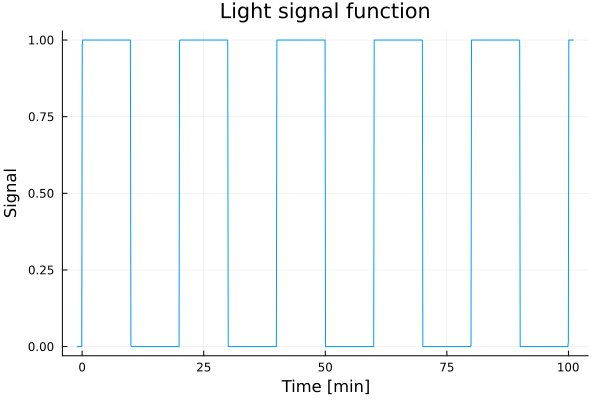

In [4]:
begin
	# Visualise the signal function
	x = LinRange(-1, 101, 1000)
	plot(x, f_signal.(x), xlabel="Time [min]", ylabel="Signal", title="Light signal function", label="")
end


#### Define ODE system



In [6]:
function erk_dynamics!(du, u, p, t)
	
	## PARAMETERS
    k_R, kd_R, GF = p[1:3]    											   # Receptor 
	k_Ras, kd_Ras, Km_Ras, Km_aRas, GAP = p[4:8]   							# Ras
	k1_Raf, k2_Raf, kd_Raf, Km_Raf, Km_aRaf, K_NFB, K_PFB, P_Raf = p[9:16]  # Raf
	k_MEK, kd_MEK, Km_MEK, Km_aMEK, P_MEK = p[17:21] 						# MEK 
	k_ERK, kd_ERK, Km_ERK, Km_aERK, P_ERK = p[22:26] 						# ERK
	k_NFB, kd_NFB, Km_NFB, Km_aR, Km_aNFB, P_NFB = p[27:32] 				# NFB
	k_PFB, kd_PFB, Km_PFB, Km_aPFB, P_PFB = p[33:37] 						# PFB
	
    ## EQUATIONS
	
    # Receptor equation
    du[1] = k_R * (1-u[1]) * GF * f_signal(t) - kd_R * u[1]
	
    # Ras equation
    du[2] = (k_Ras * u[1] * (1-u[2]) / (Km_Ras + (1-u[2])) - 
	         kd_Ras * GAP * u[2] / (Km_aRas + u[2]))
	
    # Raf equation
	du[3] = (k1_Raf * u[2] * ((1-u[3]) / (Km_Raf + (1-u[3]))) * 
	        ((K_NFB)^2 / (K_NFB^2 + u[6]^2)) - 
	         kd_Raf * P_Raf * u[3] / (Km_aRaf + u[3]) + 
	         k2_Raf * u[7] * (1-u[3]) / (K_PFB + (1-u[3])))
	
    # MEK equation
	du[4] = (k_MEK * u[3] * (1-u[4]) / (Km_MEK + (1-u[4])) - 
	         kd_MEK * P_MEK * u[4] / (Km_aMEK + u[4]))
	
    # ERK equation
	du[5] = (k_ERK * u[4] * (1-u[5]) / (Km_ERK + (1-u[5])) -
	         kd_ERK * P_ERK * u[5] / (Km_aERK + u[5]))
	
    # NFB equation
	du[6] = (k_NFB * u[5] * ((1-u[6]) / (Km_NFB + (1-u[6]))) *
	         (u[1]^2 / (Km_aR^2 + u[1]^2)) - 
	         kd_NFB * P_NFB * u[6] / (Km_aNFB + u[6]))
	
    # PFB equation
	du[7] = (k_PFB * u[5] * u[1] * (1-u[7]) / (Km_PFB + (1-u[7])) - 
	         kd_PFB * P_PFB * u[7] / (Km_aPFB + u[7]))
end

erk_dynamics! (generic function with 1 method)

In [7]:
begin
	# Define the experimental parameter for the ODE problem
	tspan = (0.0, 100.0)
	u0 = repeat([0], 7)
	p_fix = [0.5, 0.5, 25,
		 40, 3.75, 1, 1, 1,
		 10, 0, 3.75, 1, 1, 0.05, 0.01, 1,
		 2, 0.5, 1, 1, 1, 
		 2, 0.25, 1, 0.1, 1,
		 0.0286, 0.0057, 0.01, 0.85, 0.5, 1,
		 0.1, 0.005, 0.1, 0.1, 1]
	
	# Set specific parameters to current case
	p_fix[3] = GF_concentration
	p_fix[10] = GF_PFB
end

0.75


#### Simulate data with noise




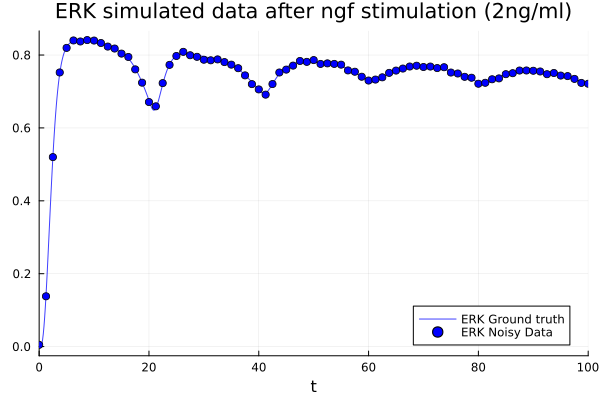

In [8]:
begin
	# Define and solve ODE problem for specific case
	prob = ModelingToolkit.ODEProblem(erk_dynamics!, u0, tspan, p_fix)
	X = OrdinaryDiffEq.solve(prob, OrdinaryDiffEq.Vern7(), abstol = 1e-12, reltol = 1e-12, saveat = 0.125)
	
	# Add noise in terms of the mean
	x_ERK = Array(X)[5,begin:10:end]
	time = X.t[begin:10:end]
	
	x̄_ERK = mean(x_ERK, dims = 1)
	noise_magnitude = 5e-3
	xₙ_ERK = abs.(x_ERK .+ (noise_magnitude * x̄_ERK) .* randn(rng, eltype(x_ERK), size(x_ERK)))
	
	plot(X, alpha = 0.75, color = :blue, 
		label = "ERK Ground truth", idxs=5, title="ERK simulated data after $(GF) stimulation ($(GF_concentration)ng/ml)")
	scatter!(time, xₙ_ERK, color = :blue, label = "ERK Noisy Data", idxs=4)
end


#### Solve UDE



In [9]:
begin
	# Multilayer FeedForward
	const U = Lux.Chain(Lux.Dense(7, 25, RBF.rbf), Lux.Dense(25, 25, RBF.rbf), Lux.Dense(25, 25, RBF.rbf), Lux.Dense(25, 25, RBF.rbf), Lux.Dense(25, 1))
	if !isnothing(retrain_file)
		
		# Load pre-trained NN parameters
		architecture = load(retrain_file)["architecture"]
		p = architecture.p
		const _st = architecture.st
	else
		# Get the initial parameters and state variables of the model
		p, st = Lux.setup(rng, U)
		const _st = st
	end
end

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple(), layer_4 = NamedTuple(), layer_5 = NamedTuple())

In [11]:
# Define the hybrid model
function ode_discovery!(du, u, p, t, p_true)
	
    # Estimate ODE solution with NN
	û = U(u, p, _st)[1]
	
    # Retrieve known parameters
	k_R, kd_R, GF = p_true[1:3]
	k_Ras, kd_Ras, Km_Ras, Km_aRas, GAP = p_true[4:8] 
	k1_Raf, k2_Raf, kd_Raf, Km_Raf, Km_aRaf, K_NFB, K_PFB, P_Raf = p_true[9:16]
	k_MEK, kd_MEK, Km_MEK, Km_aMEK, P_MEK = p_true[17:21]
	k_ERK, kd_ERK, Km_ERK, Km_aERK, P_ERK = p_true[22:26]
	k_NFB, kd_NFB, Km_NFB, Km_aR, Km_aNFB, P_NFB = p_true[27:32]
	k_PFB, kd_PFB, Km_PFB, Km_aPFB, P_PFB = p_true[33:37]
	
    # Define ODE system with unknown part
	
    # Receptor equation
    du[1] = k_R * (1-u[1]) * GF * f_signal(t) - kd_R * u[1]
	
    # Ras equation
    du[2] = (k_Ras * u[1] * (1-u[2]) / (Km_Ras + (1-u[2])) - 
	         kd_Ras * GAP * u[2] / (Km_aRas + u[2]))
	
    # Raf equation combined with NN function
	du[3] = (k1_Raf * u[2] * ((1-u[3]) / (Km_Raf + (1-u[3]))) * 
	        ((K_NFB)^2 / (K_NFB^2 + u[6]^2)) - 
	         kd_Raf * P_Raf * u[3] / (Km_aRaf + u[3]) + û[1])
	
    # MEK equation
	du[4] = (k_MEK * u[3] * (1-u[4]) / (Km_MEK + (1-u[4])) - 
	         kd_MEK * P_MEK * u[4] / (Km_aMEK + u[4]))
			 
	# ERK equation
	du[5] = (k_ERK * u[4] * (1-u[5]) / (Km_ERK + (1-u[5])) -
	         kd_ERK * P_ERK * u[5] / (Km_aERK + u[5]))
	
    # NFB equation
	du[6] = (k_NFB * u[5] * ((1-u[6]) / (Km_NFB + (1-u[6]))) * 
	         (u[1]^2 / (Km_aR^2 + u[1]^2)) - 
	         kd_NFB * P_NFB * u[6] / (Km_aNFB + u[6]))
	
    # PFB equation
	du[7] = (k_PFB * u[5] * u[1] * (1-u[7]) / (Km_PFB + (1-u[7])) - 
	         kd_PFB * P_PFB * u[7] / (Km_aPFB + u[7]))
end

ode_discovery! (generic function with 1 method)

In [12]:
begin
	# Closure with the known parameter
	nn_dynamics!(du, u, p, t) = ode_discovery!(du, u, p, t, p_fix)
	
	# Define the problem
	prob_nn = ModelingToolkit.ODEProblem(nn_dynamics!, u0, tspan, p)
end

ODEProblem with uType Vector{Int64} and tType Float64. In-place: true
timespan: (0.0, 100.0)
u0: 7-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0

In [13]:
function predict(θ, T=time)
    _prob = ModelingToolkit.remake(prob_nn, p = θ)
    X̂ = Array(OrdinaryDiffEq.solve(_prob,
		OrdinaryDiffEq.AutoVern9(OrdinaryDiffEq.Rodas5P()), saveat = T,
        abstol = 1e-12, reltol = 1e-12,
		sensealg=SciMLSensitivity.QuadratureAdjoint(autojacvec=SciMLSensitivity.ReverseDiffVJP(true))))
	return X̂
end

predict (generic function with 2 methods)

In [14]:
function loss(θ)
    X̂ = predict(θ)
    if length(X̂[5,:]) == length(xₙ_ERK)
    	mean(abs2, xₙ_ERK .- X̂[5,:])
	else
		1000
	end
end

loss (generic function with 1 method)

In [15]:
begin
	losses = Float64[]
	track = []
	callback = function(p, l)
		push!(losses, l)
		#X̂ = predict(p.u)
		#û = U(X̂, p.u, _st)[1]
		#push!(track, (X̂ = X̂, û = û))
		
        if length(losses) % 50 == 0
	        @info "Current loss after $(length(losses)) iterations: $(losses[end])"
	    end
	    return false
	end
end

#3 (generic function with 1 method)

In [16]:
begin
	# Define the optimisation problem (auto-differentiation method to compute gradient)
	adtype = Optimization.AutoZygote()
	optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
	optprob1 = Optimization.OptimizationProblem(optf, ComponentVector{Float64}(p))
end

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.28392744064331055 0.2057061791419983 … 0.11873670667409897 0.04836661368608475; -0.28952449560165405 -0.1853402554988861 … -0.19656628370285034 0.17718195915222168; … ; 0.3341655731201172 -0.296519935131073 … 0.2822721302509308 -0.0244198776781559; -0.2652294337749481 0.06949122995138168 … -0.4120776355266571 0.31138139963150024], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.04313815385103226 -0.12640956044197083 … -0.014320552349090576 -0.1892983615398407; 0.12824910879135132 -0.1304807811975479 … 0.3381803333759308 0.03638282045722008; … ; -0.24979135394096375 0.13814584910869598 … -0.2622414827346802 0.29420825839042664; -0.3260667622089386 -0.024913376197218895 … 0.26177436113357544 -0.03363973647356033], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.30194973945617676 0.334340363740921 … -0.12345290184020996 -0.02758187986910343; 0.16471698880195618 -0.282051920890808

In [18]:
begin
	# Empty the loss array
	if !isempty(losses)
    	empty!(losses)
		empty!(track)
	end
	
	# Solve UDE first by running Adam optimizer
	res1 = Optimization.solve(optprob1, OptimizationOptimisers.Adam(), 
        callback = callback, maxiters = 500)
	println("Training loss after $(length(losses)) iterations: $(losses[end])")
end

[ Info: Current loss after 50 iterations: 0.0024470946272972627
[ Info: Current loss after 100 iterations: 0.0007764527125578649
[ Info: Current loss after 150 iterations: 0.0007126553627116946
[ Info: Current loss after 200 iterations: 0.0006486353307759879
[ Info: Current loss after 250 iterations: 0.000580386115728406
[ Info: Current loss after 300 iterations: 0.0004952009746202947
[ Info: Current loss after 350 iterations: 0.00038102689762533774
[ Info: Current loss after 400 iterations: 0.00024011202162301198
[ Info: Current loss after 450 iterations: 0.00011078665432187558
[ Info: Current loss after 500 iterations: 4.271229581700067e-5


Training loss after 500 iterations: 4.271229581700067e-5


In [19]:
begin
	# Finish solving UDE by running LBFGS optimizer
	optprob2 = Optimization.OptimizationProblem(optf, res1.u)
	res2 = Optimization.solve(optprob2, 
        OptimizationOptimJL.LBFGS(linesearch = LineSearches.BackTracking()), 
        callback = callback, maxiters = 2000)
	println("Final training loss after $(length(losses)) iterations: $(losses[end])")
end

[ Info: Current loss after 550 iterations: 1.2892303464242221e-5
[ Info: Current loss after 600 iterations: 1.1395687997092474e-5
[ Info: Current loss after 650 iterations: 1.0979465588259132e-5
[ Info: Current loss after 700 iterations: 1.0579253948310055e-5
[ Info: Current loss after 750 iterations: 1.0399374983705103e-5
[ Info: Current loss after 800 iterations: 1.0306178271584107e-5
[ Info: Current loss after 850 iterations: 9.943450350928586e-6
[ Info: Current loss after 900 iterations: 9.912892486316024e-6
[ Info: Current loss after 950 iterations: 9.720431105150188e-6
[ Info: Current loss after 1000 iterations: 9.597716690304598e-6
[ Info: Current loss after 1050 iterations: 9.55027103803843e-6
[ Info: Current loss after 1100 iterations: 9.492130571901705e-6
[ Info: Current loss after 1150 iterations: 9.434630293709035e-6
[ Info: Current loss after 1200 iterations: 9.259375021945133e-6
[ Info: Current loss after 1250 iterations: 9.188030341503589e-6
[ Info: Current loss after 13

Final training loss after 2501 iterations: 7.90584253685873e-6


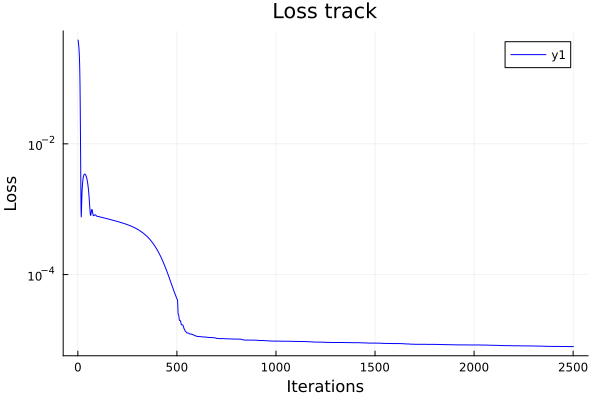

In [20]:
begin
	# Plot the losses
	pl_losses = plot(1:length(losses), losses[1:end], yaxis = :log10,
	                 xlabel = "Iterations", ylabel = "Loss", color = :blue, title="Loss track")
end

In [21]:
begin
	# Retrieve the trained parameters and get EGF/NGF model estimations
	p_trained = res2.u
	ts = first(X.t):(mean(diff(X.t))):last(X.t)
	X̂ = predict(p_trained, ts)
	
    # Estimate UDE unknown part
	û = U(X̂, p_trained, _st)[1]
	
    # Establish ground truth for unkown part of ODE system
	u = (p_fix[10] .* X[7,:] .* (1 .- X[3,:]) ./ (p_fix[15] .+ (1 .- X[3,:])))
end

801-element Vector{Float64}:
 0.0
 2.39163753782418e-9
 2.42643646264322e-7
 3.094422305332313e-6
 1.6905414344156003e-5
 5.8042949722723734e-5
 0.00014929031026654285
 0.0003169019844381403
 0.0005880287934312378
 0.000988660979142954
 0.0015422483436553964
 0.002268894058295788
 0.0031849021898447093
 ⋮
 0.7121446378628582
 0.7117464877685876
 0.7113473369416776
 0.710947238758058
 0.7105462439719059
 0.7101444008161963
 0.7097417551054928
 0.7093383503393572
 0.7089342278051177
 0.7085294266790265
 0.7081239841250965
 0.7077182646644187


#### Visualisation of the results



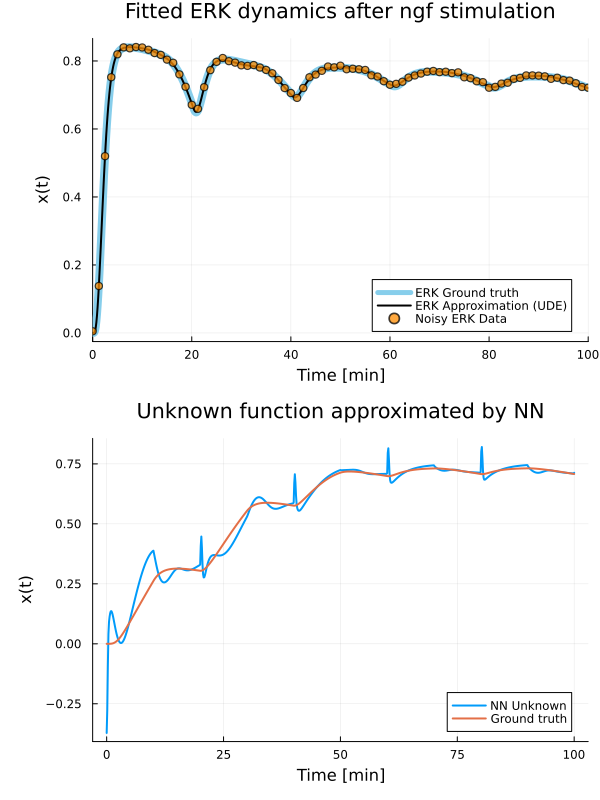

In [22]:
begin 
	# Plot the simulated data, trained solution and ground truth ERK dynamics
	p1 = plot(X, color = :skyblue, linewidth=8, label = "ERK Ground truth", idxs=5)
	plot!(p1, ts, X̂[5,:], xlabel = "Time [min]", ylabel = "x(t)", left_margin=(7,:mm), color = :black, linewidth=2, label = "ERK Approximation (UDE)", title="Fitted ERK dynamics after $(GF) stimulation")
	scatter!(p1, time, xₙ_ERK, color = :darkorange, alpha=0.75, label = "Noisy ERK Data")
	
	# Plot unknown part approximated by NN with ground truth
	p2 = plot(ts, û[1,:], label="NN Unknown", linewidth=2, title="Unknown function approximated by NN", xlabel = "Time [min]", ylabel = "x(t)", left_margin=(7,:mm),)
	plot!(p2, X.t, u, linewidth=2, label="Ground truth", legend_position=:bottomright)
	
    # Final two panels plot
	nn_plot = plot(p1, p2, layout=(2,1), size=(600, 800))
	
    #savefig(nn_plot, "../Plots/$(filename)_nn_plot.svg")
end

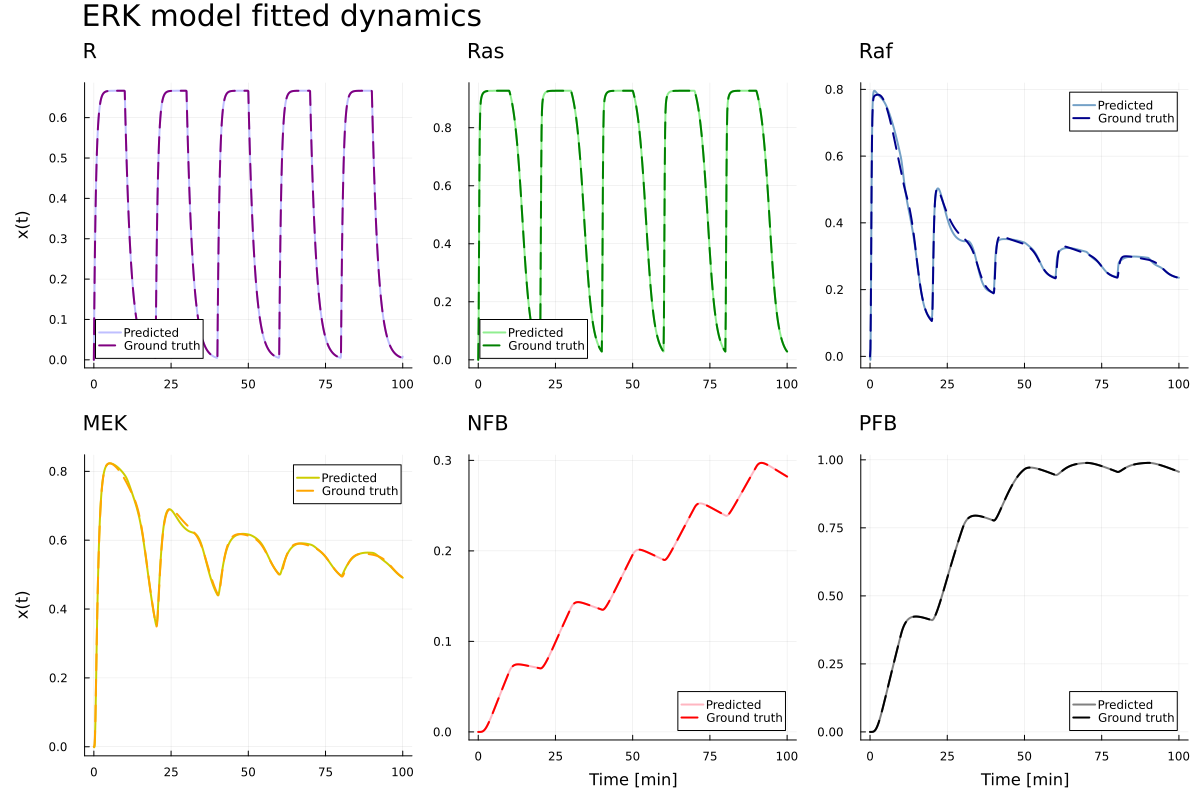

In [23]:
begin
	# Plot UDE full results for all model species
	R_plot = plot(ts, X̂[1,:], label="Predicted", alpha = 0.25, color = :blue, linewidth=2, title="R", titlelocation=:left)
	plot!(X.t, X[1,:], label="Ground truth", linestyle=:dash, colour=:purple, linewidth=2, ylabel = "x(t)", left_margin=(7,:mm))
	
	Ras_plot = plot(ts, X̂[2,:], label="Predicted", colour=:lightgreen, linewidth=2, title="Ras", titlelocation=:left)
	plot!(X.t, X[2,:], label="Ground truth", linestyle=:dash, colour=:green, linewidth=2)
	
	Raf_plot = plot(ts, X̂[3,:], label="Predicted", colour=:steelblue, alpha=0.75, linewidth=2, title="Raf", titlelocation=:left)
	plot!(X.t, X[3,:], label="Ground truth", linestyle=:dash, colour=:darkblue, linewidth=2)
	MEK_plot = plot(ts, X̂[4,:], label="Predicted", colour=:yellow3, linewidth=2, title="MEK", titlelocation=:left)
	plot!(X.t, X[4,:], label="Ground truth", linestyle=:dash, colour=:orange, linewidth=2, ylabel = "x(t)", left_margin=(7,:mm))
	ERK_plot = plot(ts, X̂[5,:], label="Predicted", colour=:blue, linewidth=2, title="ERK", titlelocation=:left)
	plot!(X.t, X[5,:], label="Ground truth", linestyle=:dash, colour=:darkblue, linewidth=2)
	NFB_plot = plot(ts, X̂[6,:], label="Predicted", colour=:lightpink, linewidth=2, title="NFB", titlelocation=:left)
	plot!(X.t, X[6,:], label="Ground truth", linestyle=:dash, colour=:red, linewidth=2, xlabel = "Time [min]", legend_position=:bottomright)
	
	PFB_plot = plot(ts, X̂[7,:], label="Predicted", colour=:grey, linewidth=2, title="PFB", titlelocation=:left)
	plot!(X.t, X[7,:], label="Ground truth", colour=:black, linewidth=2, linestyle=:dash, legend_position=:bottomright, xlabel = "Time [min]")
	
    #Final multipanel plot
	full_plot = plot(R_plot, Ras_plot, Raf_plot, MEK_plot, NFB_plot, PFB_plot, layout=(2,3), size=(1200, 800), top_margin=(4,:mm), bottom_margin=(4,:mm), plot_title="ERK model fitted dynamics", plot_titlefontsize=20, plot_titlelocation=:left)
	#savefig("../Plots/$(filename)_full_plot.svg")
end


#### Saving results



In [24]:
# Save the tracking data
#jldsave("../Data/erk_anim_data.jld2"; anim_data = (track=track, df=df))

In [25]:
# Save the parameters
if !isnothing(save_file)
	jldsave(save_file; architecture = (p=res2.u, st=architecture.st))
end

In [26]:
begin
	# Save NN approximation with the fitted and GT ODE solution for equation discovery
	erk_data = zeros(length(û[1,:]))
	time_data = zeros(length(û[1,:]))
	erk_data[begin:length(xₙ_ERK)] = xₙ_ERK
	time_data[begin:length(time)] = time
	df = DataFrame((
		time=ts,
		t_data=time_data,
		ERK_data=erk_data,
		NN_approx=û[1,:],
		NN_GT=u,
		R_fit=X̂[1,:], 
		Ras_fit=X̂[2,:],
		Raf_fit=X̂[3,:],
		MEK_fit=X̂[4,:],
		ERK_fit=X̂[5,:],
		NFB_fit=X̂[6,:],
		PFB_fit=X̂[7,:],
		R_GT=X[1,:],
		Ras_GT=X[2,:],
		Raf_GT=X[3,:],
		MEK_GT=X[4,:],
		ERK_GT=X[5,:],
		NFB_GT=X[6,:],
		PFB_GT=X[7,:]))
	if !isnothing(filename)
		#CSV.write("../Data/$(filename).csv", df, header=true)
	end
end